# PN2V Training
Here we will use the estimated noise model (from ```1a_CreateNoiseModel_GMM``` or ```1b_CreateNoiseModel_Histogram```) and train a PN2V network on single noisy images.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v import utils
from pn2v import gaussianMixtureNoiseModel
from pn2v import histNoiseModel
from pn2v import training
from tifffile import imread
import os
import urllib
import zipfile
import torch
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

Load the data that needs to be denoised. It is expected that you have downloaded the datasets from  https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download and created a noise model (either GMM based or histogram based, using either the notebook ```1a_CreateNoiseModel_GMM.ipynb``` or ```1b_CreateNoiseModel_Histogram.ipynb```). Ensure that for Convallaria, the data to be denoised is named ```20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif``` and not the diaphragm data. For your dataset, ensure that you load the right data. 

In [2]:
path='../../../data/Convallaria_diaphragm/'
# Load the training data
data=imread(path+'20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif')
typeNoiseModel='GMM' # Specify either 'GMM' or 'histogram'

In [3]:
if (typeNoiseModel == 'GMM'):
    n_gaussian = 3 # If using GMM noise model, specify number of Gaussians created in 1a_CreateNoiseModel_GMM.ipynb
    n_coeff = 2 # If using GMM noise model, specify number of coefficients created in 1a_CreateNoiseModel_GMM.ipynb
dataName = 'convallaria' # dataname chosen in `1x_CreateNoiseModel_GMM.ipynb`. This is used to load the right noise model.
mode = 'bootstrap' # Either 'bootstrap'(bootstrapping mode) or 'calibration'(using calibration data)

In [4]:
if(typeNoiseModel=='GMM'):
    namePN2VModel=dataName+'_GMM_'+str(n_gaussian)+'gaussian_'+str(n_coeff)+'coefficients_'+mode
    params= np.load(path+'trained_weights_minSignal_maxSignal_GMM_'+dataName+'_'+str(n_gaussian)+'gaussian_'+str(n_coeff)+'coefficients_'+mode+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params['min_signal'][0], params['max_signal'][0],
                                                                     torch.Tensor(params['trained_weight']))
else:
    namePN2VModel=dataName+'_histogram_'+mode
    histogram = np.load(path+'noiseModelHistogram_'+ dataName+'_'+mode+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)

/home/lalit/Desktop/01_Softwares/anaconda3/envs/ppn2vEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


### Create the Network and Train it
This can take a while.

In [5]:
# Create a network with 800 output channels that are interpreted as samples from the prior.
net = UNet(800, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()
np.random.shuffle(my_train_data)
np.random.shuffle(my_val_data)

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=namePN2VModel, directory=path, noiseModel=noiseModel,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

../../unet/model.py:215: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
../../unet/model.py:216: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


Epoch 0 finished      
avg. loss: 7.128427577018738+-(2SEM)0.1413327967225108      
Epoch 1 finished      
avg. loss: 6.783323788642884+-(2SEM)0.1506122600040752      
Epoch 2 finished      
avg. loss: 6.67761492729187+-(2SEM)0.1280610930285182      
Epoch 3 finished      
avg. loss: 6.548898816108704+-(2SEM)0.12244112096035602      
Epoch 4 finished      
avg. loss: 6.357431149482727+-(2SEM)0.11052110573752948      
Epoch 5 finished      
avg. loss: 6.318774843215943+-(2SEM)0.13257887767894141      
Epoch 6 finished      
avg. loss: 6.317973637580872+-(2SEM)0.13243247718209733      
Epoch 7 finished      
avg. loss: 6.133956551551819+-(2SEM)0.09805351572707578      
Epoch 8 finished      
avg. loss: 6.2194836139678955+-(2SEM)0.10290348563939074      
Epoch 9 finished      
avg. loss: 6.1658648490905765+-(2SEM)0.07001931516820346      
Epoch 10 finished      
avg. loss: 6.257883358001709+-(2SEM)0.12203466968646741      
Epoch 11 finished      
avg. loss: 6.196266984939575+-(2SEM)0.0870

avg. loss: 6.260820031166077+-(2SEM)0.09537085736482602      
Epoch 92 finished      
avg. loss: 6.144604301452636+-(2SEM)0.11785902175816178      
Epoch 93 finished      
avg. loss: 6.119586634635925+-(2SEM)0.07536651385039661      
Epoch    93: reducing learning rate of group 0 to 7.8125e-06.
Epoch 94 finished      
avg. loss: 6.033525037765503+-(2SEM)0.0565937433746066      
Epoch 95 finished      
avg. loss: 6.174332404136658+-(2SEM)0.10511631533040985      
Epoch 96 finished      
avg. loss: 6.099026918411255+-(2SEM)0.10171917485931942      
Epoch 97 finished      
avg. loss: 6.161565685272217+-(2SEM)0.1288248836300141      
Epoch 98 finished      
avg. loss: 6.166541218757629+-(2SEM)0.08604767301582628      
Epoch 99 finished      
avg. loss: 6.156289863586426+-(2SEM)0.11007875660994453      
Epoch 100 finished      
avg. loss: 6.121123838424682+-(2SEM)0.09641744169671776      
Epoch 101 finished      
avg. loss: 6.240453243255615+-(2SEM)0.09870131442243556      
Epoch 102 finish

avg. loss: 6.142174816131591+-(2SEM)0.11541640292280374      
Epoch 181 finished      
avg. loss: 6.1938232421875+-(2SEM)0.06493974343378417      
Epoch   181: reducing learning rate of group 0 to 3.0518e-08.
Epoch 182 finished      
avg. loss: 6.058733248710633+-(2SEM)0.08602659885928716      
Epoch 183 finished      
avg. loss: 6.200676298141479+-(2SEM)0.10340063429560525      
Epoch 184 finished      
avg. loss: 6.160763216018677+-(2SEM)0.1136192771658563      
Epoch 185 finished      
avg. loss: 6.1747273206710815+-(2SEM)0.10165333546871982      
Epoch 186 finished      
avg. loss: 6.209130144119262+-(2SEM)0.09836887811472173      
Epoch 187 finished      
avg. loss: 6.1446418285369875+-(2SEM)0.10144534827547148      
Epoch 188 finished      
avg. loss: 6.067460703849792+-(2SEM)0.08443230499405947      
Epoch 189 finished      
avg. loss: 6.043056511878968+-(2SEM)0.07868747031753402      
Epoch 190 finished      
avg. loss: 6.227157521247864+-(2SEM)0.1079845044497697      
Epoch 19

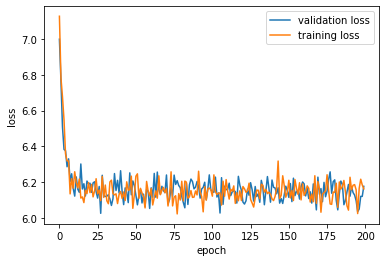

In [7]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()